In [2]:
import sys
lib_path = '/home/jovyan/libs'
sys.path.insert(0, lib_path)

In [3]:
import gc, math, traceback, datetime
from functools import lru_cache

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from datasets import load_from_disk

from tqdm import tqdm

from utils import audio, attention
from utils.attacks import PrepareMethod, PrepareFront

In [4]:
model, processor = attention.init()

/home/jovyan/libs/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
validation = load_from_disk("../tedlium/test.hf").with_format("torch")

In [9]:
tester = validation[2]["audio"]

In [10]:
validation[2]

{'audio': tensor([ 0.0035,  0.0146, -0.0050,  ..., -0.0046, -0.0051, -0.0043]),
 'text': 'now i have a plan for this and it entails convincing more people including all of you to spend more time'}

In [11]:
@lru_cache
def bypass(model, processor, audio):
    eot_idx = processor.tokenizer.eos_token_id
    _, res, _, _, _, _ = attention.inference(audio, model, processor)
    dcder_hidden_states = torch.stack([torch.stack(r) for r in res.decoder_hidden_states[1:]]).squeeze()
    if dcder_hidden_states.dim() == 2:
        return None
    else:
        return torch.nn.Softmax(dim=2)(model.proj_out(dcder_hidden_states))[:, :, processor.tokenizer.eos_token_id].detach().cpu()

# Unattacked

In [12]:
res = bypass(model, processor, tester).permute(1, 0)

/home/jovyan/libs/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
WhisperModel is using WhisperSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `layer_head_mask` not None. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [13]:
r = res[:, -1]
r.shape # this is of shape (heads + 1, sequence length)

torch.Size([5])

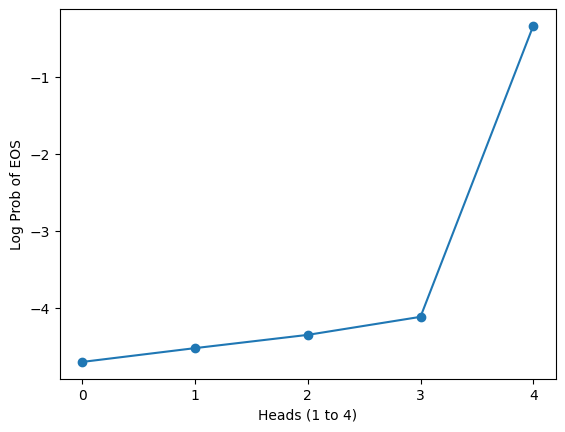

In [14]:
import matplotlib.pyplot as plt
plt.plot(torch.log10(r), marker="o")
plt.xlabel("Heads (1 to 4)")
plt.ylabel("Log Prob of EOS")
plt.xticks(torch.arange(0, 5))
plt.show()

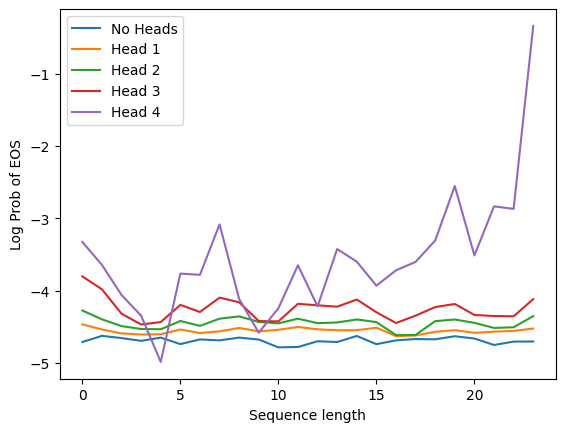

In [15]:
for i, head in enumerate(res):
    plt.plot(torch.log10(head), label="No Heads" if i == 0 else f"Head {i}")
plt.xlabel("Sequence length")
plt.ylabel("Log Prob of EOS")
plt.legend()
plt.show()

# Attacked

In [183]:
snippets = torch.load("tensors/snippets.pt", weights_only=True).detach()
snippets.shape

torch.Size([16, 10240])

In [193]:
snippet = snippets[-1,:]

In [194]:
attacked = torch.cat([snippet, tester])

In [195]:
res = bypass(model, processor, attacked)
assert res is not None, "res is None!"

AssertionError: res is None!

In [196]:
r = res[:, :]
r.shape # this is of shape (heads, sequence length)

TypeError: 'NoneType' object is not subscriptable

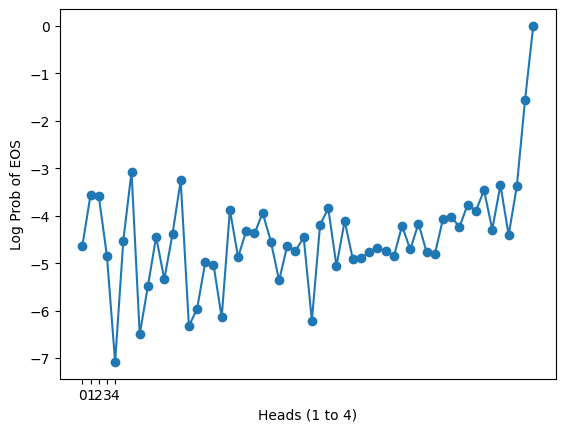

In [191]:
plt.plot(torch.log10(r), marker="o")
plt.xlabel("Heads (1 to 4)")
plt.ylabel("Log Prob of EOS")
plt.xticks(torch.arange(0, 5))
plt.show()